In [1]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/noqula/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [2]:
import tensorflow as tf
print(tf.__version__)


2025-12-01 16:04:13.493291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 16:04:13.785872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764597853.890346  735175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764597853.916765  735175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764597854.139972  735175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.0


In [3]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Generate input data


# Fidelity calculation functions

def fidelity_imag(y_pred1, y_true1):
    y_pred_imag = y_pred1
    y_true_imag = y_true1
    ai = y_pred_imag
    bi = y_true_imag
    ci = ai * bi
    F_imag = (np.mean(ci) - np.mean(ai) * np.mean(bi)) / (
        (np.mean(np.square(ai)) - np.square(np.mean(ai))) *
        (np.mean(np.square(bi)) - np.square(np.mean(bi))) 
        )** 0.5
    return F_imag

# Create neural network model
def create_model(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(40, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(20, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(10, activation="relu", kernel_initializer="glorot_uniform")(x)
    output = Dense(1)(x)
    model = Model(x_input, output)
    return model

def create_model1(input_shape): #model to prevent overfitting
    # Input layer
    x_input = Input(shape=input_shape, name="x_input")
    # First Dense layer with L2 regularization and Dropout
    x = Dense(40, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Second Dense layer with L2 regularization and Dropout
    x = Dense(20, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Third Dense layer with L2 regularization and Dropout
    x = Dense(10, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Output layer
    output = Dense(1)(x)
    # Create and return the model
    model = Model(x_input, output)
    return model



In [5]:
# Add noise to data
def adding_noise(p1, q1, noise_std):
    noise1 = np.random.normal(0, noise_std, size=p1.shape)
    noise2 = np.random.normal(0, noise_std, size=q1.shape)
    p2 = np.concatenate([p1, p1 + noise1], axis=0)
    q2 = np.concatenate([q1, q1 + noise2], axis=0)  
    indices = np.arange(len(p2))
    np.random.shuffle(indices)
    return p2[indices], q2[indices]



def adding_noise_log(p1, q1, noise_std):
    noise1 = np.random.lognormal(mean=0.0, sigma=noise_std, size=p1.shape)
    noise2 = np.random.lognormal(mean=0.0, sigma=noise_std, size=q1.shape)
    p2 = p1 * noise1  # Multiplicative noise keeps values non-negative
    q2 = q1 * noise2
    return p2, q2

In [6]:
def eigensys(v):
    N = len(v)
    H1 = np.diag( (v) * (-1j)) + 0.82*np.eye(N, k=1) + 0.82*np.eye(N, k=-1)
    return H1*2.*np.pi

def gpower(w11, vl, vp, freq1):
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11+ 1j * 0.01), axis=1))))
   # pw = np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * 0.01), axis=1)))
    return pw #/np.pi

def gpower_edited(w11, vl, vp, angular_freq1):
    #pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * 0.01), axis=1))))
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (angular_freq1 - w11+ 1j *0.1), axis=1))))
    return pw

def orthomatrix(vl21, vl22):
    M = np.conj(vl21.T) @ vl22
    return M

def newbiorth1(vl11, vl12,N1):
    M = orthomatrix(vl11, vl12)
    #print(M)
    p, l, u = linalg.lu(M)
    linv = linalg.inv(p @ l)
    uinv = linalg.inv(u)
    vlp1 = linv @ np.conj(np.transpose(vl11))
    vlp2 = vl12 @ uinv
    M1 = vlp1 @ vlp2
    is_biorthogonal = np.allclose(M1, np.eye(N1), atol=1e-10)
    #print(f"Biorthogonality check: {'Passed' if is_biorthogonal else 'Failed'}")
    #print(M1)
    return np.conj(np.transpose(vlp1)), vlp2

In [7]:
import numpy as np
import os

# Define file path
folder_name = "results_for_random_onsite_losses"
#file_pathy = os.path.join(folder_name, "onsite_loss.txt")
#file_pathy = os.path.join("onsite_lossesinGH.txt")
file_pathy = os.path.join("onsite_lossesinGHz_afteradding_intrinsicloss.txt")


# Load the data (assuming space-separated values)
datay = np.loadtxt(file_pathy, delimiter=" ")

# Flatten the data row-wise into a single column
y = datay.flatten()

# Print shape to verify (should be 1D)
print("y shape:", y.shape)

# Optional: Save Y as a single column file
#output_file = os.path.join(folder_name, "onsite_loss_column.txt")
#np.savetxt(output_file, y, fmt="%.18f")

#print(f"y saved as a single column in {output_file}")
file_pathx = os.path.join("full.txt") #without the compensation of intrinsic losses in the system
#file_pathx = os.path.join(folder_name, "compensated_spectral_data.txt") #after including the compensation of intrinsic losses
#file_pathx = os.path.join("compensated_spectral_data.txt") #after including the compensation of intrinsic losses

# Load the data as a 2D NumPy array
X_dB = np.loadtxt(file_pathx, delimiter=" ")
X = 10**(X_dB/10) 
# Print shape to verify
print("X shape:", X.shape)

#print(np.sum(X,axis=1).shape)
#print(X_train1)
#print(y_train1.shape)


y shape: (1600,)
X shape: (1600, 40)


In [8]:
from sklearn.model_selection import train_test_split

num_sites = 8
num_chains = len(y) // num_sites

# Create group IDs
group_ids = np.arange(num_chains)

# Split by chains
train_chains, test_chains = train_test_split(group_ids, test_size=0.2, random_state=42)

# Now build train/test sets site-by-site, but only from the chosen chains
train_mask = np.isin(np.repeat(group_ids, num_sites), train_chains)
test_mask  = np.isin(np.repeat(group_ids, num_sites), test_chains)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
groups_train    = np.repeat(train_chains, num_sites)
groups_test     = np.repeat(test_chains, num_sites)




#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(1280, 40)
(320, 40)


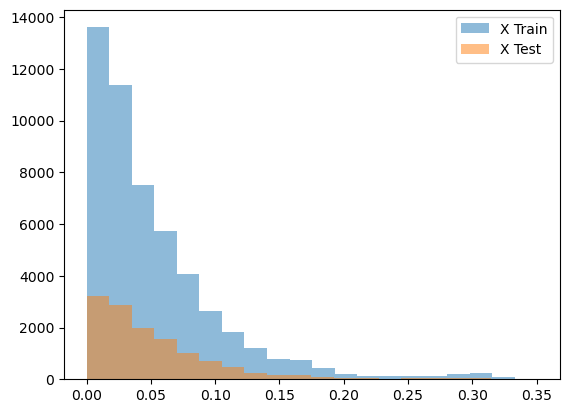

In [9]:
import matplotlib.pyplot as plt
plt.hist(X_train.flatten(), bins=20, alpha=0.5, label="X Train")
plt.hist(X_test.flatten(), bins=20, alpha=0.5, label="X Test")
plt.legend()
plt.show()

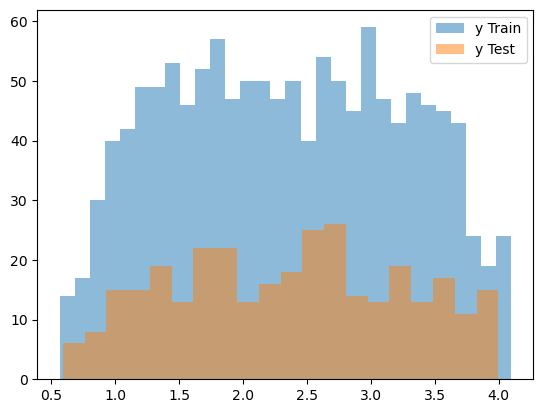

In [10]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=30, alpha=0.5, label="y Train")
plt.hist(y_test.flatten(), bins=20, alpha=0.5, label="y Test")
plt.legend()
plt.show()

In [11]:
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

#scalery = StandardScaler()
#y_train_scaled = scalery.fit_transform(y_train)
#y_test_scaled = scalery.transform(y_test)
y_train_scaled = y_train
y_test_scaled = y_test

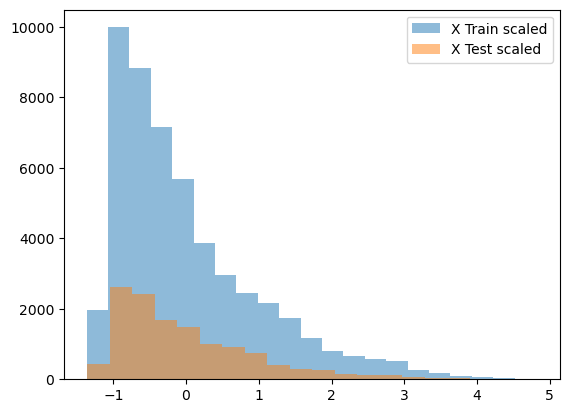

In [12]:
import matplotlib.pyplot as plt
plt.hist(X_train_scaled.flatten(), bins=20, alpha=0.5, label="X Train scaled")
plt.hist(X_test_scaled.flatten(), bins=20, alpha=0.5, label="X Test scaled")
plt.legend()
plt.show()

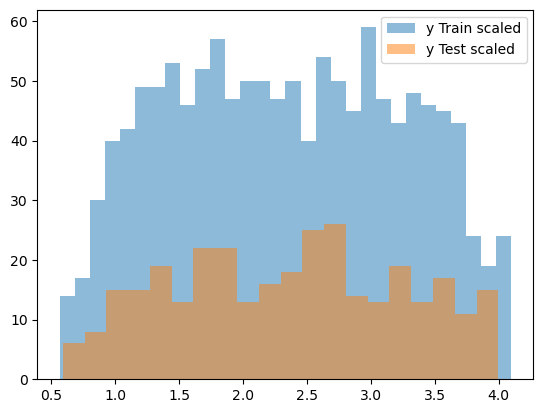

In [13]:
import matplotlib.pyplot as plt
plt.hist(y_train_scaled.flatten(), bins=30, alpha=0.5, label="y Train scaled")
plt.hist(y_test_scaled.flatten(), bins=20, alpha=0.5, label="y Test scaled")
plt.legend()
plt.show()

In [14]:
model = create_model(input_shape=X_train.shape[1:])
#model = create_model1(input_shape=X_train_scaled.shape[1:])
model.compile(optimizer="adam", loss="mse")
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=16, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

loss = model.evaluate(X_test_scaled, y_test_scaled)
#print(f"Test Loss (noise_std={noise_std}):", loss)

# Predictions
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print(y_pred_train.shape)
print(y_train.shape)
print(y_pred_test.shape)
print(y_test.shape)

Epoch 1/200


2025-12-01 16:04:27.293666: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4118 - val_loss: 1.8193
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3315 - val_loss: 0.7882
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5234 - val_loss: 0.4112
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3299 - val_loss: 0.2590
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2107 - val_loss: 0.2070
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1749 - val_loss: 0.1720
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1449 - val_loss: 0.1393
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1258 - val_loss: 0.1510
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1207 - val_loss: 0.1205
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1026 - val_loss: 0.1062
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0907 - val_loss: 0.0999
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837 - val_lo

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288 - val_loss: 0.0243
Epoch 70/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324 - val_loss: 0.0609
Epoch 71/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0376 - val_loss: 0.0256
Epoch 72/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324 - val_loss: 0.0451
Epoch 73/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0315 - val_loss: 0.0252
Epoch 74/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 - val_loss: 0.0207
Epoch 75/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0232 - val_loss: 0.0249
Epoch 76/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - val_loss: 0.0364
Epoch 77/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 - val_loss: 0.0338
Epoch 78/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 79/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0329 - val_loss: 0.0255
Epoch 80/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249 

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 - val_loss: 0.0166
Epoch 138/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0294 - val_loss: 0.0168
Epoch 139/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 - val_loss: 0.0196
Epoch 140/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 141/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0215 - val_loss: 0.0156
Epoch 142/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - val_loss: 0.0324
Epoch 143/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0186 - val_loss: 0.0304
Epoch 144/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0241 - val_loss: 0.0257
Epoch 145/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 146/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 - val_loss: 0.0367
Epoch 147/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0167
Epoch 148/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

In [15]:
y_pred_train = np.squeeze(y_pred_train)  # Flattening to shape (40000,)
y_train1 = np.squeeze(y_train_scaled)
y_pred_test = np.squeeze(y_pred_test)  # Flattening to shape (40000,)
y_test1 = np.squeeze(y_test_scaled)
print(np.max(y_pred_test))
# Fidelity
F_imag_train = fidelity_imag(y_pred_train, y_train1)
F_imag = fidelity_imag(y_pred_test, y_test1)
    
print(f"Fidelity (Imag): Train ( {F_imag_train:.4f}), Test ({F_imag:.4f})")

# Diagnostics: Check for constant outputs
print(f"Variance of Predictions (Train): {np.var(y_pred_train, axis=0)}")
print(f"Variance of Predictions (Test): {np.var(y_pred_test, axis=0)}")

# Save results
#with open("mllresults6.dat", "a") as file21:
#    file21.write(f"{noise_std} {F_real_train:.4f} {F_imag_train:.4f} {F_real:.4f} {F_imag:.4f}\n")

3.9660275
Fidelity (Imag): Train ( 0.9888), Test (0.9892)
Variance of Predictions (Train): 0.7294548749923706
Variance of Predictions (Test): 0.7030462026596069


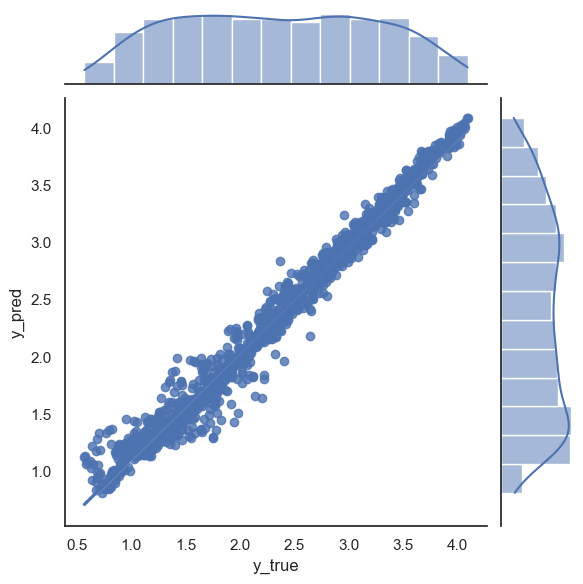

In [16]:
import pandas as pd
import seaborn as sns
y_true = y_train_scaled
y_pred = y_pred_train

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_train, kind="reg")

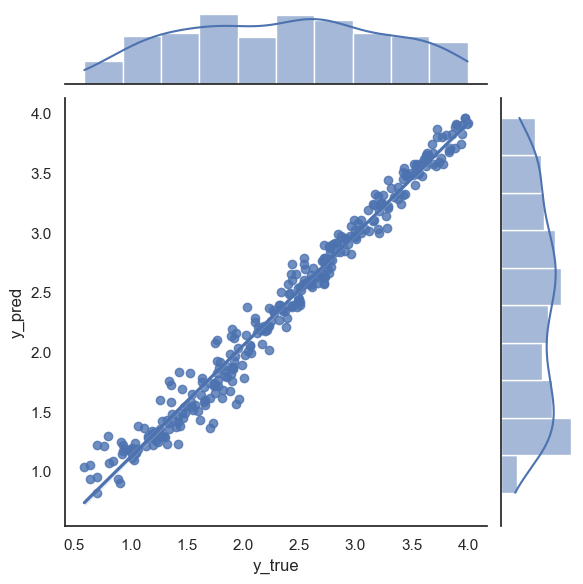

In [17]:
import pandas as pd
import seaborn as sns
y_true = y_test_scaled
y_pred = y_pred_test

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_test, kind="reg")

In [18]:


# Initialize containers
predicted_losses_grouped_train = []
true_losses_grouped_train = []
predicted_losses_grouped_test = []
true_losses_grouped_test = []

# ---- Train regrouping ----
unique_chains_train = np.unique(groups_train)

for chain_id in unique_chains_train:
    idx = np.where(groups_train == chain_id)[0]
    idx_sorted = np.sort(idx)

    predicted_chain_losses = y_pred_train[idx_sorted]
    true_chain_losses = y_train[idx_sorted]

    predicted_losses_grouped_train.append(predicted_chain_losses)
    true_losses_grouped_train.append(true_chain_losses)

# ---- Test regrouping ----
unique_chains_test = np.unique(groups_test)

for chain_id in unique_chains_test:
    idx = np.where(groups_test == chain_id)[0]
    idx_sorted = np.sort(idx)

    predicted_chain_losses = y_pred_test[idx_sorted]
    true_chain_losses = y_test[idx_sorted]

    predicted_losses_grouped_test.append(predicted_chain_losses)
    true_losses_grouped_test.append(true_chain_losses)

# Convert to arrays
predicted_losses_grouped_train = np.array(predicted_losses_grouped_train)  # (num_chains_train, 8)
true_losses_grouped_train = np.array(true_losses_grouped_train)

predicted_losses_grouped_test = np.array(predicted_losses_grouped_test)    # (num_chains_test, 8)
true_losses_grouped_test = np.array(true_losses_grouped_test)

# Shapes check
print("Train predicted shape:", predicted_losses_grouped_train.shape)
print("Train true shape:", true_losses_grouped_train.shape)
print("Test predicted shape:", predicted_losses_grouped_test.shape)
print("Test true shape:", true_losses_grouped_test.shape)


Train predicted shape: (160, 8)
Train true shape: (160, 8)
Test predicted shape: (40, 8)
Test true shape: (40, 8)


In [19]:
#import numpy as np

#np.savez_compressed(
#    "predicted_losses_grouped_data.npz",
#    predicted_losses_grouped_train=predicted_losses_grouped_train,
#    predicted_losses_grouped_test=predicted_losses_grouped_test,
#)


In [20]:
# Create neural network model
def create_model_sanity_test(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(40, activation="linear")(x)  # Output dimension is 40
    model = Model(inputs=x_input, outputs=x)
    return model

def create_model_sanity_test1(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    x = Dense(128, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    
    x = Dense(40, activation="linear")(x)  # Output dimension is 40 for regression
    
    model = Model(inputs=x_input, outputs=x)
    return model

from tensorflow.keras import layers, Model, Input

def create_stage2_cnn(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x_input)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(input_shape[0], activation='linear')(x)
    return Model(inputs=x_input, outputs=x)

def create_stage2_cnn_balanced(input_shape):
    l2_reg = 5e-4  # Slightly lighter than before
    dropout_conv = 0.2
    dropout_dense = 0.4
    
    x_input = Input(shape=input_shape, name="x_input")
    
    # Small Gaussian noise at input for robustness
    x = layers.GaussianNoise(0.02)(x_input)
    
    # Conv Block 1
    x = layers.Conv1D(32, 7, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv Block 2
    x = layers.Conv1D(64, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv Block 3
    x = layers.Conv1D(64, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense Layers
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_dense)(x)
    
    output = layers.Dense(input_shape[0], activation='linear')(x)
    
    model = Model(inputs=x_input, outputs=output)
    return model

In [21]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Self-attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward
    ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff)
    return layers.LayerNormalization(epsilon=1e-6)(ff + x)

def create_spectrum_transformer(input_shape, num_layers=4):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)

    # Predict one output per frequency point
    x = layers.Dense(1, activation='linear')(x)       # (batch, n_freq, 1)
    outputs = layers.Reshape((input_shape[0],))(x)    # (batch, n_freq)
    return Model(inputs, outputs)

from tensorflow.keras import regularizers


def create_stage2_cnn1(input_shape):
    l2_reg = 1e-3  # Adjust if needed

    x_input = Input(shape=input_shape, name="x_input")

    x = layers.Conv1D(64, 7, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(input_shape[0], activation='linear')(x)

    return Model(inputs=x_input, outputs=output)

def create_stage2_cnn_balanced(input_shape):
    l2_reg = 5e-4  # Slightly lighter than before
    dropout_conv = 0.2
    dropout_dense = 0.4
    
    x_input = Input(shape=input_shape, name="x_input")
    
    # Small Gaussian noise at input for robustness
    x = layers.GaussianNoise(0.02)(x_input)
    
    # Conv Block 1
    x = layers.Conv1D(32, 7, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv Block 2
    x = layers.Conv1D(64, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv Block 3
    x = layers.Conv1D(64, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense Layers
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_dense)(x)
    
    output = layers.Dense(input_shape[0], activation='linear')(x)
    
    model = Model(inputs=x_input, outputs=output)
    return model


In [22]:
# generating theoretical data

file_pathfrequencies = os.path.join("frequencies.txt")
frequencies = 2.*np.pi*np.loadtxt(file_pathfrequencies, delimiter=" ")

frequencies_num = list(enumerate(frequencies))
print("length of frequencies :", len(frequencies))  
file_pathy1 = os.path.join("onsite_lossesinGHz_afteradding_intrinsicloss.txt")
#file_pathy1 = os.path.join("onsite_lossesinGH.txt")


# Load the data (assuming space-separated values)
datay1_train = predicted_losses_grouped_train #y_pred_train.reshape(-1,8)
true_datay1_train = true_losses_grouped_train
print("datay1_train shape:", datay1_train.shape)
    
X1_train = np.zeros((datay1_train.shape[0] *datay1_train.shape[1] , len(frequencies)), dtype=np.float64)
true_X1_train = np.zeros((true_datay1_train.shape[0] *true_datay1_train.shape[1] , len(frequencies)), dtype=np.float64)


for i1 in range(datay1_train.shape[0]):
    ww = 2.*np.random.rand(datay1_train.shape[1]-1)-1
    Ham = eigensys(datay1_train[i1,:])#+ np.diag(ww, 1) + np.diag(ww, -1)
    w, vl1, vl2 = linalg.eig(Ham, left=True, right=True)
    vlp1, vlp2 = newbiorth1(vl1, vl2,datay1_train.shape[1])
    
    true_Ham = eigensys(true_datay1_train[i1,:])
    true_w, true_vl1, true_vl2 = linalg.eig(true_Ham, left=True, right=True)
    true_vlp1, true_vlp2 = newbiorth1(true_vl1, true_vl2,true_datay1_train.shape[1])
    
    for i2, freq in frequencies_num:
        X1_train[i1 * datay1_train.shape[1]: (i1 + 1) * datay1_train.shape[1], i2] = gpower_edited(w, vlp1, vlp2, freq)  
       
        true_X1_train[i1 * true_datay1_train.shape[1]: (i1 + 1) * true_datay1_train.shape[1], i2] = gpower_edited(true_w, true_vlp1, true_vlp2, freq)  
print("X1_train shape :", X1_train.shape)
print("true X1_train shape :", true_X1_train.shape) 

datay1_test = predicted_losses_grouped_test #y_pred_test.reshape(-1,8)
print("datay1_test shape:", datay1_test.shape)
    
X1_test = np.zeros((datay1_test.shape[0] *datay1_test.shape[1] , len(frequencies)), dtype=np.float64)

for i1 in range(datay1_test.shape[0]):
    ww1 = 2.*np.random.rand(datay1_train.shape[1]-1)-1
    Ham_test = eigensys(datay1_test[i1,:])#+ np.diag(ww1, 1) + np.diag(ww1, -1)
    w_test, vl1_test, vl2_test = linalg.eig(Ham_test, left=True, right=True)
    vlp1_test, vlp2_test = newbiorth1(vl1_test, vl2_test,datay1_test.shape[1])
    for i2, freq in frequencies_num:
        X1_test[i1 * datay1_test.shape[1]: (i1 + 1) * datay1_test.shape[1], i2] = gpower_edited(w_test, vlp1_test, vlp2_test, freq)  
print("X1_test shape :", X1_test.shape) 


length of frequencies : 40
datay1_train shape: (160, 8)
X1_train shape : (1280, 40)
true X1_train shape : (1280, 40)
datay1_test shape: (40, 8)
X1_test shape : (320, 40)


In [23]:
new_X_train = X1_train
new_y_train = X_train/(2. * datay1_train.flatten()[:, np.newaxis] * 2 * np.pi)
new_X_test = X1_test
new_y_test = X_test/(2. * datay1_test.flatten()[:, np.newaxis] * 2 * np.pi)

In [24]:
#import numpy as np

## Save all arrays in one compressed file
#np.savez_compressed(
#    "train_test_data_stage2.npz",
#    new_X_train=new_X_train,
#    new_y_train=new_y_train,
#    new_X_test=new_X_test,
#    new_y_test=new_y_test
#)


In [25]:
from sklearn.metrics import mean_squared_error
chain_mse = []
for i in range(X1_train.shape[0] // 8):
    chain_mse.append(
        mean_squared_error(true_X1_train[i*8:(i+1)*8], X1_train[i*8:(i+1)*8])
    )
print(np.mean(chain_mse), np.std(chain_mse))



4.3326409014241484e-07 9.469536912586193e-07


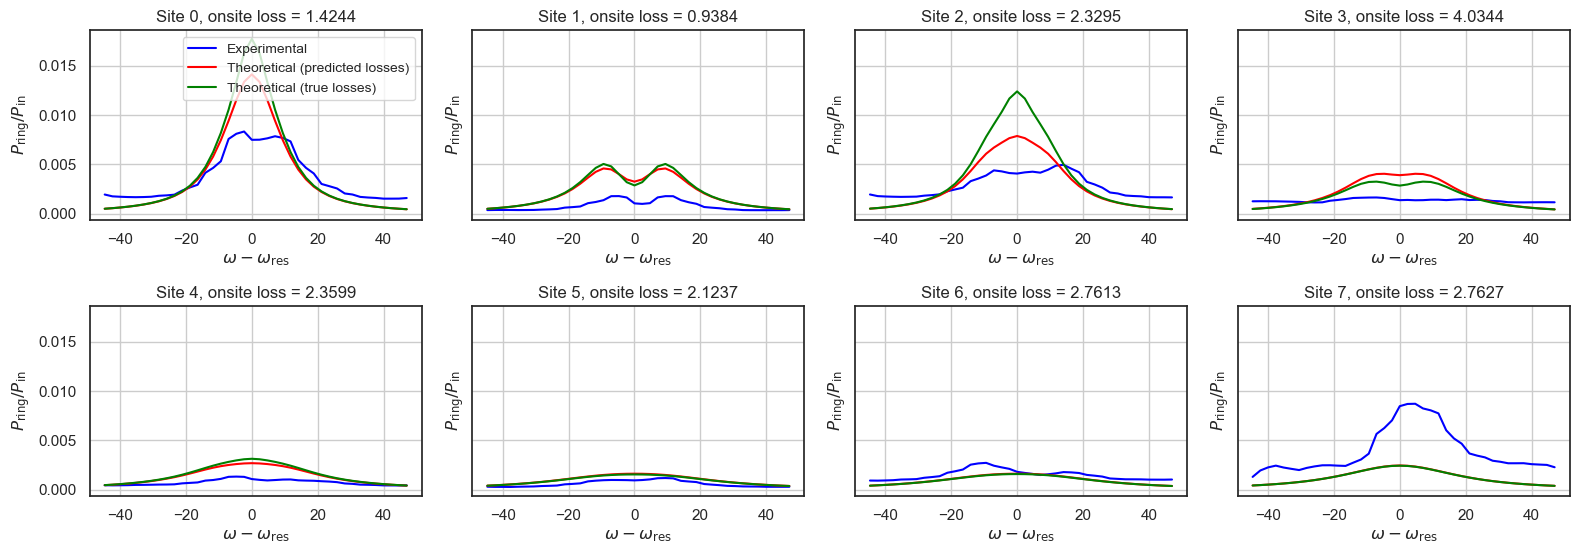

In [26]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 0
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, new_y_train[i+(8*k), :], label='Experimental', color='blue')
    ax.plot(frequencies, new_X_train[i+(8*k), :], label='Theoretical (predicted losses)', color='red')
    ax.plot(frequencies, true_X1_train[i+(8*k), :], label='Theoretical (true losses)', color='green')


    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {datay[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [27]:
from sklearn.preprocessing import QuantileTransformer
#scalernx = QuantileTransformer(output_distribution="normal", n_quantiles=1000)
#scalerny = QuantileTransformer(output_distribution="normal", n_quantiles=1000)

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline
#scalernx = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
#scalerny = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())


scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)

scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)

#new_X_train_scaled = new_X_train
#new_X_test_scaled = new_X_test
#new_y_train_scaled = new_y_train
#new_y_test_scaled = new_y_test

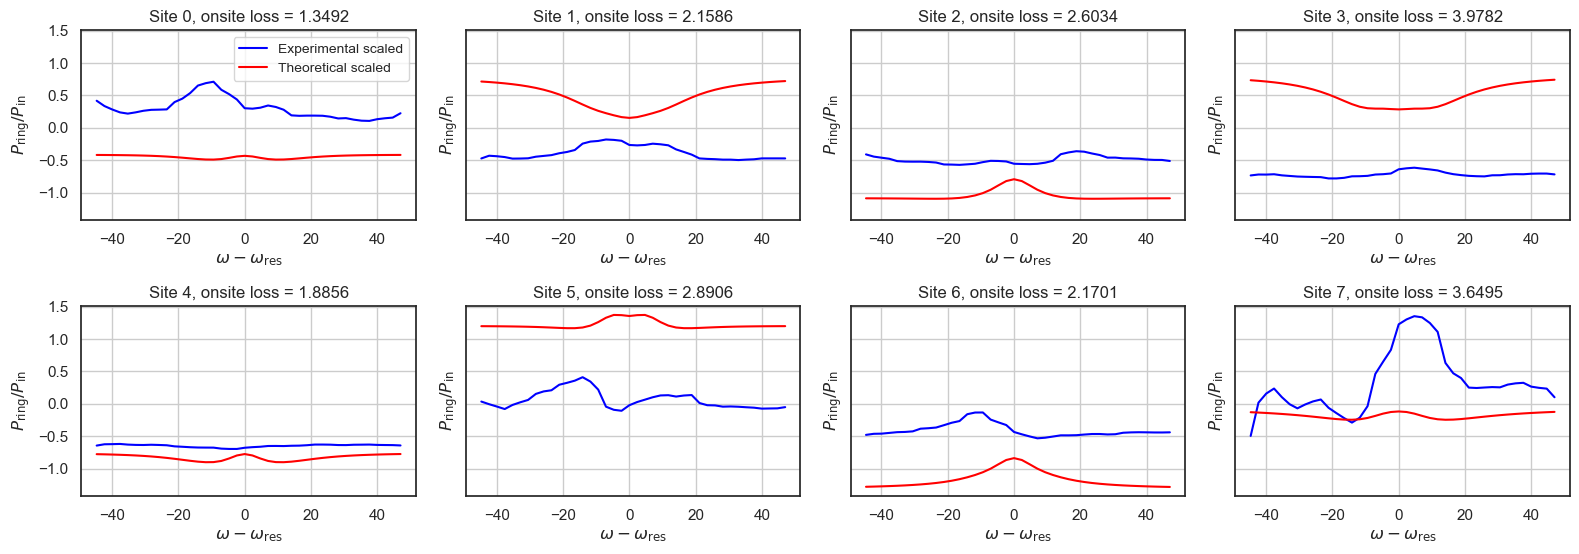

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 23
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(frequencies, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {datay[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [29]:
#model_sc = create_model_sanity_test(input_shape=new_X_train_scaled.shape[1:])
#model_sc = create_model_sanity_test1(input_shape=new_X_train_scaled.shape[1:])
# Prepare data with channel dim
new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn  = new_X_test_scaled[..., np.newaxis]

# Build CNN model
#model_sc = create_stage2_cnn1(input_shape=new_X_train_scaled_cnn.shape[1:])
model_sc = create_stage2_cnn_balanced((40, 1))
model_sc.compile(optimizer="adam", loss="mse")


# Train
history_sc = model_sc.fit(new_X_train_scaled_cnn, new_y_train_scaled,epochs=100, batch_size=40, validation_split=0.2)


# Evaluate
loss = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled)
print(f"Test Loss: {loss:.6f}")


#model_sc.compile(optimizer="adam", loss="mse")

#history_sc = model_sc.fit(new_X_train_scaled, new_y_train_scaled, epochs=100, batch_size=16, validation_split=0.2)

#loss_sc = model_sc.evaluate(new_X_test_scaled, new_y_test_scaled)
#print(f"Test Loss :", loss_sc)
#model_sc = create_spectrum_transformer(new_X_train_scaled_cnn.shape[1:])
#model_sc.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')

# Train with early stopping
#history = model_sc.fit(  new_X_train_scaled_cnn, new_y_train_scaled, validation_split=0.2, epochs=200, batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

# Evaluate
#loss = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled)
#print(f"Test Loss: {loss:.6f}")

# Predictions
new_y_pred_test = model_sc.predict(new_X_test_scaled_cnn)
new_y_pred_train = model_sc.predict(new_X_train_scaled_cnn)

print(new_y_pred_train.shape)
print(new_y_train.shape)
print(new_y_pred_test.shape)
print(new_y_test.shape)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.4074 - val_loss: 0.9195
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7558 - val_loss: 0.9282
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6993 - val_loss: 0.9471
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5327 - val_loss: 0.9405
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4678 - val_loss: 0.9586
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3557 - val_loss: 0.9443
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4071 - val_loss: 0.9589
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2186 - val_loss: 0.9072
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1586 - val_loss: 0.9151
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1139 - val_loss: 0.8981
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1046 - val_loss: 0.8640
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6450 - val_loss: 0.6019
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6448 - val_loss: 0.5687
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7003 - val_loss: 0.5339
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7564 - val_loss: 0.5877
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6895 - val_loss: 0.5646
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6715 - val_loss: 0.5524
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8344 - val_loss: 0.5582
Epoch 76/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7132 - val_loss: 0.5554
Epoch 77/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6748 - val_loss: 0.6020
Epoch 78/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6496 - val_loss: 0.5237
Epoch 79/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6426 - val_loss: 0.5420
Epoch 80/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6255 

In [30]:
y_sample = model_sc.predict(new_X_train_scaled_cnn[:5])
print("Prediction shape:", y_sample.shape)   # should be (5, 40)
print("First prediction-second prediction:", y_sample[0]-y_sample[1])      # should vary, not constant


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Prediction shape: (5, 40)
First prediction-second prediction: [2.3899684 2.4309406 2.4104853 2.3976831 2.4196558 2.385196  2.442086
 2.4316134 2.4415367 2.3909545 2.4058483 2.4340851 2.5574994 2.629358
 2.72007   3.0415094 3.1079006 3.151655  3.2565866 3.2476785 3.2036648
 2.9228435 2.8030643 2.6617906 2.1819952 2.0049517 1.9460473 2.0432684
 2.0896063 2.1379826 2.2103302 2.1839166 2.1827893 2.2153828 2.3405752
 2.34997   2.3657417 2.237697  2.148325  1.9879825]


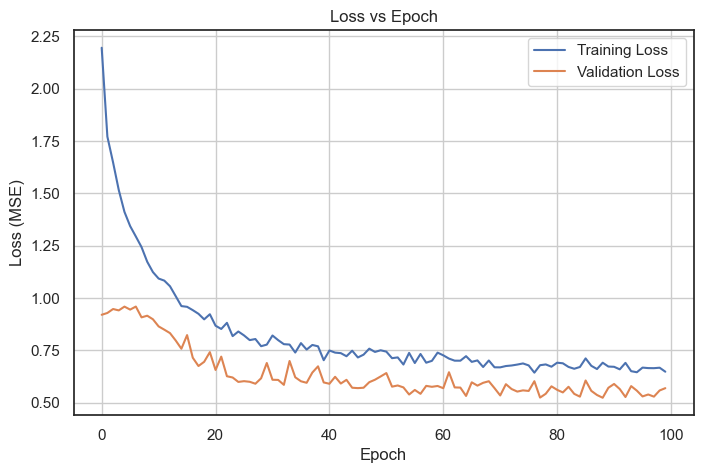

In [31]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc.history['loss']
val_loss = history_sc.history['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)

#pred_y_train = new_y_pred_train
#pred_y_test = new_y_pred_test

true_y_train = new_y_train
true_y_test = new_y_test


In [76]:
print(pred_y_test.shape)
print(datay1_test.flatten().shape)


(320, 40)
(320,)


In [77]:
print(datay1_test.flatten())

[2.270332   1.189825   3.5629377  1.4120059  2.2152245  2.5757995
 2.6048567  2.2229269  2.715901   1.9693465  2.6561625  3.1081326
 2.6050584  3.711592   3.583082   2.213531   2.2930293  3.4759378
 2.5655887  1.2340318  3.922506   3.498183   3.5806053  2.584378
 1.5826386  2.0624058  2.1915405  3.403566   3.6554704  1.1759588
 3.3066976  1.6444044  2.176761   1.2845873  2.9014533  3.0844152
 1.6517041  1.3579258  2.7033365  1.3441747  2.8279772  2.5376346
 3.5501866  2.7920413  2.331715   1.8244374  3.2534235  2.1622245
 1.7699265  1.9906001  1.8337965  2.8396041  1.870477   1.5837574
 1.1916819  1.1612238  3.2825432  1.2146503  1.3821042  1.5685515
 3.6699998  3.5421052  3.3797235  1.2387835  3.2440639  2.3931692
 2.7790973  2.6713254  2.7402678  2.3537545  1.2477044  3.5761442
 1.042363   3.4776669  2.5010755  3.618769   2.8719563  1.3418722
 1.4681426  1.5196692  2.3795466  2.789243   3.6531749  3.114114
 2.505774   1.7837399  1.4239907  2.9756954  1.2919304  3.2521198
 1.3184944  

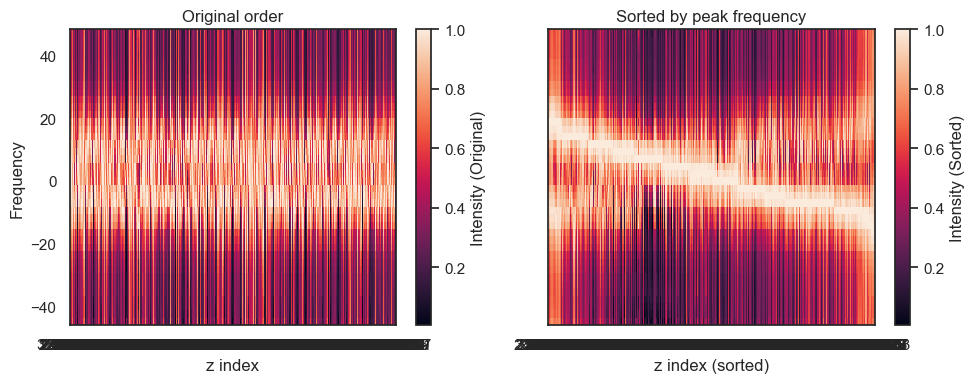

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(datay1_test.flatten())
frequencies1 = np.array(frequencies)
#S = np.array(true_y_test)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)

# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T,
    shading='auto')#,vmin=0., vmax=0.8)
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [79]:
print(S[3,:])

[0.32985142 0.33269193 0.33316532 0.32817155 0.32360531 0.32797301
 0.33628076 0.35628654 0.36943542 0.44451059 0.47503858 0.51926513
 0.60109036 0.65936687 0.69446097 0.74878212 0.80722656 0.87452845
 0.96782275 1.         0.99923645 0.90633935 0.90116217 0.9003222
 0.7954827  0.74128378 0.70765562 0.58849127 0.53472    0.47593956
 0.37384889 0.35043752 0.34081639 0.33148548 0.33356241 0.33363877
 0.33582259 0.34051098 0.34594767 0.36172326]


In [80]:
#Sk = np.array(pred_y_test)
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)
Sk_new = Sk[order, :]

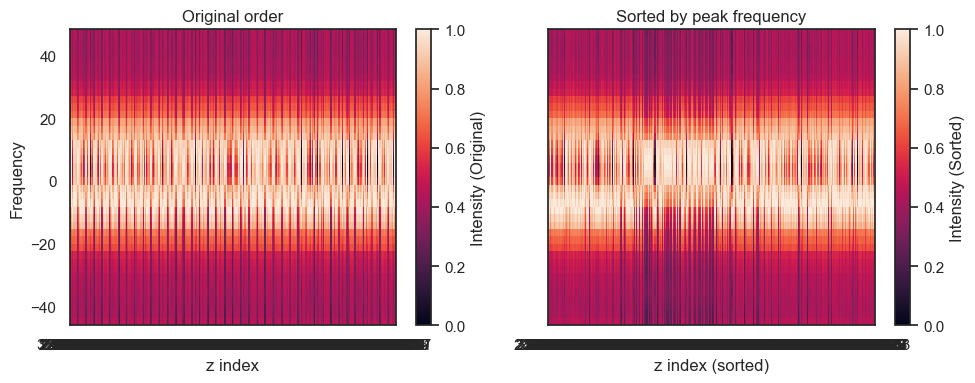

In [81]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto',vmin=0)
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto',vmin=0)
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [84]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted_new.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)


✅ Saved spectra_sorted.dat with shape (12800, 5)


"Stop here below is hilbert space fitting"

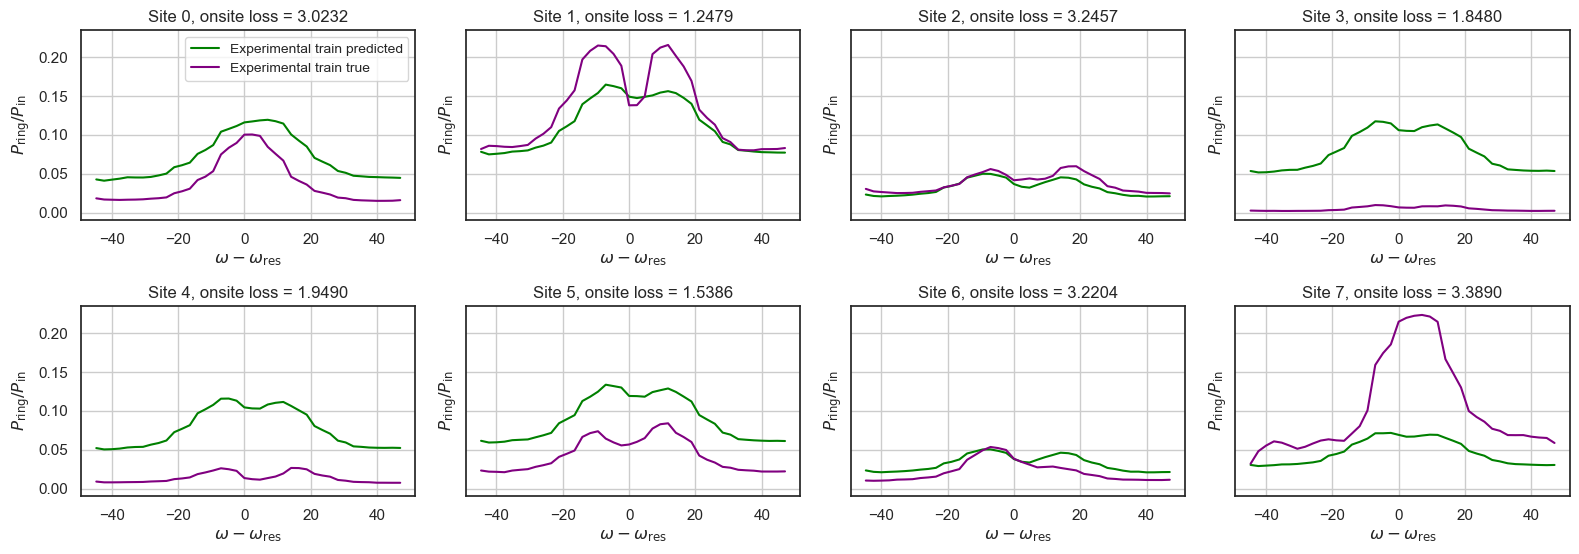

In [54]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 20
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_train[i+(8*k), :]/(np.max(pred_y_train)), label='Experimental train predicted', color='green')
    ax.plot(frequencies, true_y_train[i+(8*k), :]/(np.max(true_y_train)), label='Experimental train true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {datay1_train[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

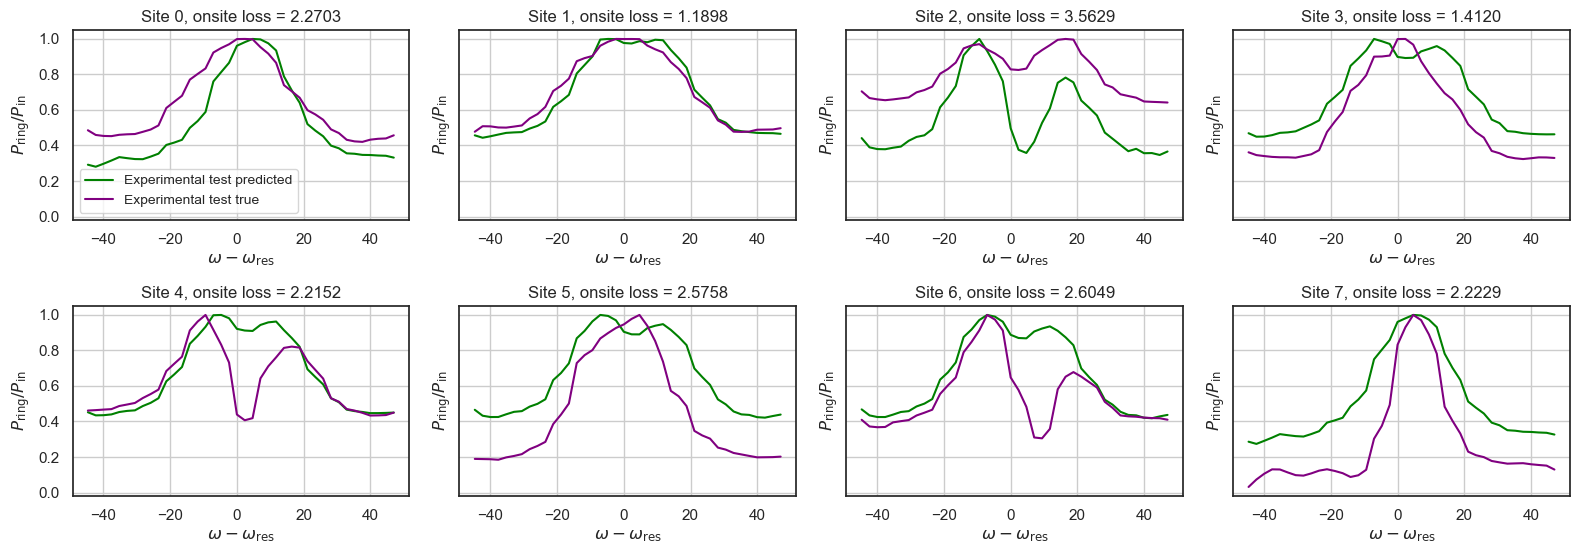

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k =0
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_test[i+(8*k), :]/(np.max(pred_y_test[i+(8*k), :])), label='Experimental test predicted', color='green')
    ax.plot(frequencies, true_y_test[i+(8*k), :]/(np.max(true_y_test[i+(8*k), :])), label='Experimental test true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {datay1_test[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
import os
import numpy as np

def save_by_m(frequencies, pred_y_test, true_y_test, datay1_test,
              out_dir="out_by_m", delimiter="\t"):
    """
    Save 8 files, one for each m in [0..7], aggregating over all k.
    Each file has columns:
        k, m, freq, pred, true, loss

    Shapes assumed (consistent with your original indexing):
      - frequencies: (F,)
      - pred_y_test / true_y_test: stacked as idx = m + 8*k, each row length F
      - datay1_test: shape (K, 8) giving the 'loss' per (k, m)
    """
    os.makedirs(out_dir, exist_ok=True)
    F = frequencies.shape[0]
    K = datay1_test.shape[0]

    for m in range(8):
        rows = []
        for k in range(K):
            idx = m + 8 * k
            loss = float(datay1_test[k, m])
            block = np.column_stack([
                np.full(F, k, dtype=int),     # k
                np.full(F, m, dtype=int),     # m (constant within this file)
                frequencies,                  # freq
                pred_y_test[idx],             # pred
                true_y_test[idx],             # true
                np.full(F, loss, dtype=float) # loss (per k,m)
            ])
            rows.append(block)

        M = np.vstack(rows)
        out_path = os.path.join(out_dir, f"m{m}_allk_freq_pred_true_loss.dat")
        header = "k\tm\tfreq\tpred\ttrue\tloss"
        np.savetxt(out_path, M,
                   fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g"],
                   delimiter=delimiter, header=header, comments="")
        print(f"Saved {out_path} | shape={M.shape}")


In [36]:
#save_by_m(
#    frequencies=frequencies,
#    pred_y_test=pred_y_test,
#    true_y_test=true_y_test,
#    datay1_test=datay1_test,
#    out_dir="out_by_m"   # folder where the 8 files will be saved
#)


In [37]:
import numpy as np

# ---------- Hilbert utils ----------
def _rot(n, x, y, rx, ry):
    if ry == 0:
        if rx == 1:
            x = n - 1 - x
            y = n - 1 - y
        x, y = y, x
    return x, y

def _xy2d(n, x, y):
    d = 0
    s = n // 2
    while s > 0:
        rx = 1 if (x & s) else 0
        ry = 1 if (y & s) else 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = _rot(s, x, y, rx, ry)
        s //= 2
    return d

# -----------------------------------

def hilbert_xyz_any_sign(x, y, k=16):
    """
    Forward + backward mapping between real (x,y) and Hilbert z.
    Works for negative x,y.
    Returns (x_scaled, y_scaled, z)
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    assert x.shape == y.shape

    # Normalize
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    xr = (x - x_min) / (x_max - x_min + 1e-15)
    yr = (y - y_min) / (y_max - y_min + 1e-15)

    N = 1 << k
    scale = N - 1
    xi = np.clip((xr * scale).round().astype(np.uint32), 0, scale)
    yi = np.clip((yr * scale).round().astype(np.uint32), 0, scale)

    # Hilbert index
    z = np.fromiter((_xy2d(N, int(a), int(b)) for a, b in zip(xi, yi)),
                    dtype=np.uint64, count=len(xi))
    z_scaled = (z - z.min()) / (z.max() - z.min())
    return x, y, z_scaled

In [38]:
x = np.arange(8)
Nx = 8
R = datay1_test.shape[0]
y = datay1_test
y_grid = y.reshape(Nx, R)        # (Nx, R)
x_pairs = np.repeat(x, R)        # (Nx*R,)
y_pairs = y_grid.reshape(-1)     # (Nx*R,)
x1, y1, z = hilbert_xyz_any_sign(x_pairs, y_pairs, k=10)

In [39]:
assert len(np.unique(y_pairs, axis=0)) == len(np.unique(z))
print(len(np.unique(z)),len(z))

AssertionError: 

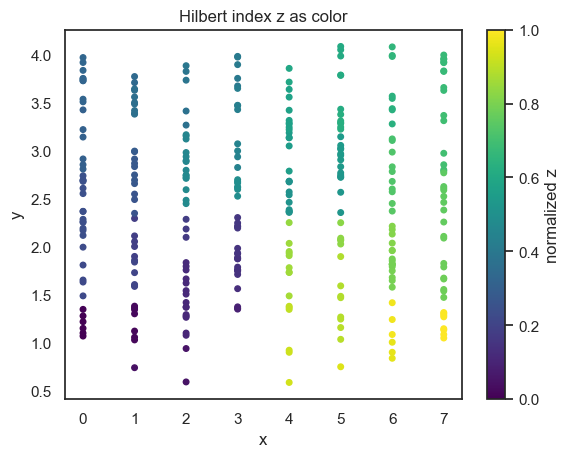

In [40]:
import matplotlib.pyplot as plt
plt.scatter(x_pairs, y_pairs, c=z, s=16, cmap='viridis')
plt.xlabel("x"); plt.ylabel("y")
plt.title("Hilbert index z as color")
plt.colorbar(label="normalized z")
plt.show()

In [41]:
_, counts = np.unique(z, return_counts=True)
print("Collisions:", np.sum(counts > 1))


Collisions: 8


In [42]:
z_unique = z.astype(np.float64) + 1e-9 * np.arange(len(z))


In [43]:
assert len(np.unique(y_pairs, axis=0)) == len(np.unique(z_unique))
print(len(np.unique(z_unique)),len(z_unique))

320 320


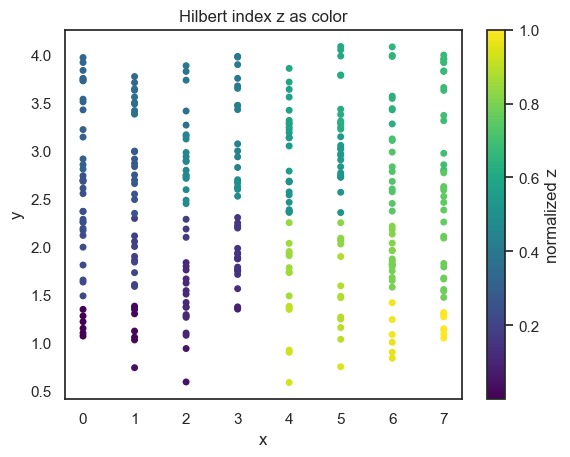

In [44]:
import matplotlib.pyplot as plt
plt.scatter(x_pairs, y_pairs, c=z_unique, s=16, cmap='viridis')
plt.xlabel("x"); plt.ylabel("y")
plt.title("Hilbert index z as color")
plt.colorbar(label="normalized z")
plt.show()

In [45]:
import numpy as np

def save_all_km_single(frequencies, pred_y_test, true_y_test,
                       datay1_test=None,  # optional: loss per (k,m)
                       z=None,            # optional: Hilbert-curve value(s)
                       out_path="all_k_m_freq_pred_true_loss_z.dat",
                       delimiter="\t"):
    """
    Save ONE file stacking all k and m (0..7) over all frequencies.
    Columns: k, m, freq, pred, true, loss, z

    Assumptions:
      - frequencies: shape (F,)
      - pred_y_test / true_y_test are stacked with idx = m + 8*k, each row length F
      - If datay1_test is provided: shape (K, 8) giving 'loss' per (k,m)
      - z can be:
          * None -> column filled with NaN
          * shape (K, 8) -> scalar per (k,m), broadcast across F
          * shape (K, 8, F) -> value per (k,m,f)
    """
    frequencies = np.asarray(frequencies)
    F = frequencies.shape[0]

    pred_y_test = np.asarray(pred_y_test)
    true_y_test = np.asarray(true_y_test)

    # infer K from stacked rows length
    if pred_y_test.ndim != 2 or pred_y_test.shape[1] != F:
        raise ValueError("pred_y_test must be 2D with shape (8*K, F)")
    if true_y_test.shape != pred_y_test.shape:
        raise ValueError("true_y_test shape must match pred_y_test")

    rows_stacked = pred_y_test.shape[0]
    if rows_stacked % 8 != 0:
        raise ValueError("pred_y_test rows not divisible by 8; cannot infer K")
    K = rows_stacked // 8

    # prepare loss
    if datay1_test is None:
        datay1_test = np.full((K, 8), np.nan, dtype=float)
    else:
        datay1_test = np.asarray(datay1_test)
        if datay1_test.shape != (K, 8):
            raise ValueError(f"datay1_test must have shape (K, 8) = ({K}, 8)")

    # prepare z
    z_mode = "none"
    if z is None:
        # fill later with NaN
        pass
    else:
        z = np.asarray(z)
        if z.shape == (K, 8):
            z_mode = "km"
        elif z.shape == (K, 8, F):
            z_mode = "kmf"
        else:
            raise ValueError(f"z must have shape (K,8) or (K,8,F); got {z.shape}")

    blocks = []
    for k in range(K):
        for m in range(8):
            idx = m + 8 * k
            loss_km = float(datay1_test[k, m])

            # choose z column for this (k,m)
            if z_mode == "none":
                z_col = np.full(F, np.nan, dtype=float)
            elif z_mode == "km":
                z_col = np.full(F, float(z[k, m]), dtype=float)
            else:  # "kmf"
                z_col = z[k, m].astype(float)

            block = np.column_stack([
                np.full(F, k, dtype=int),          # k
                np.full(F, m, dtype=int),          # m
                frequencies,                       # freq
                pred_y_test[idx],                  # pred
                true_y_test[idx],                  # true
                np.full(F, loss_km, dtype=float),  # loss
                z_col                               # z
            ])
            blocks.append(block)

    M = np.vstack(blocks)

    header = "k\tm\tfreq\tpred\ttrue\tloss\tz"
    np.savetxt(out_path, M,
               fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g","%.10g"],
               delimiter=delimiter, header=header, comments="")
    print(f"Saved {out_path} | shape={M.shape} | K={K}, F={F}")


In [46]:
K = 40                              # number of k’s
F = frequencies.shape[0]            # number of frequency samples

# z_flat has length 8*K (320). Match idx = m + 8*k  → row=k, col=m
z_km = z_unique.reshape(K, 8)         # shape (K, 8): z[k, m]

# (Optional) quick sanity check: z_km[k, m] == z_flat[m + 8*k]
# assert np.allclose(z_km.ravel(order="C"), z_flat)

#save_all_km_single(
#    frequencies=frequencies,        # shape (F,)
#    pred_y_test=pred_y_test,        # shape (8*K, F) stacked with idx = m + 8*k
#    true_y_test=true_y_test,        # shape (8*K, F) same stacking
#    datay1_test=datay1_test,        # shape (K, 8) losses per (k, m). Or pass None.
#    z=z_km,                         # shape (K, 8) → broadcast across frequencies
#    out_path="all_km_freq_pred_true_loss_z.dat"
#)


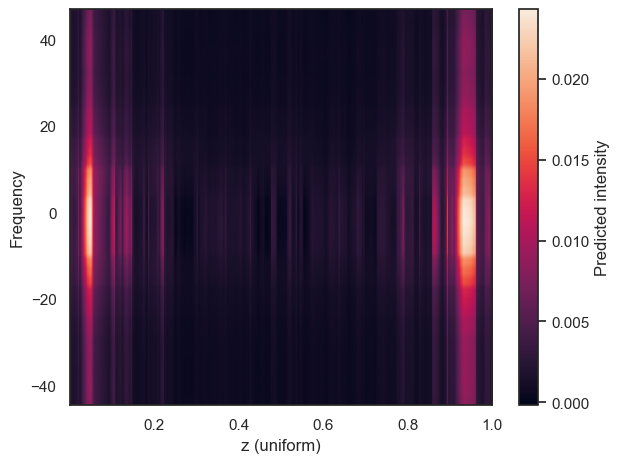

In [47]:
from scipy.interpolate import interp1d

N = pred_y_test.shape[0]
z = z_unique.copy()
order = np.argsort(z)
z_sorted = z[order]
Z_p = pred_y_test[order, :]                      # (N, F)

# Build a uniform z axis
z_uniform = np.linspace(z_sorted.min(), z_sorted.max(), N)

# Interpolate each frequency column onto uniform z
Z_uniform_p = np.empty_like(Z_p)
for j in range(Z_p.shape[1]):
    f = interp1d(z_sorted, Z_p[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_p[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_p.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='Predicted intensity')
plt.tight_layout()
plt.show()


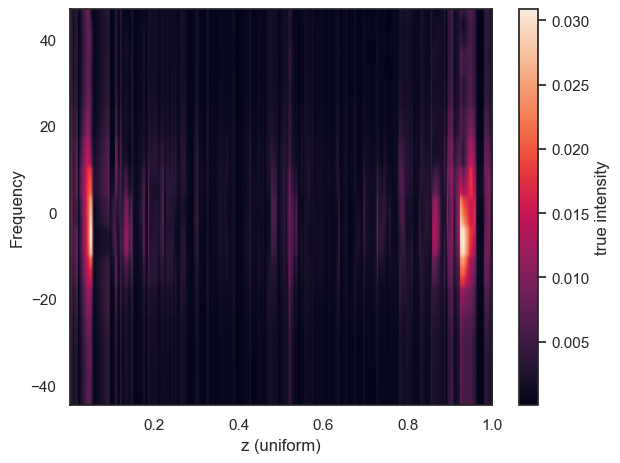

In [48]:
from scipy.interpolate import interp1d

Z_t = true_y_test[order, :]                      # (N, F)


# Interpolate each frequency column onto uniform z
Z_uniform_t = np.empty_like(Z_t)
for j in range(Z_t.shape[1]):
    f = interp1d(z_sorted, Z_t[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_t[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_t.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='true intensity')
plt.tight_layout()
plt.show()

In [49]:
K = 40                              # number of k’s
F = frequencies.shape[0]            # number of frequency samples

# z_flat has length 8*K (320). Match idx = m + 8*k  → row=k, col=m
z_km = z_uniform.reshape(K, 8)         # shape (K, 8): z[k, m]

# (Optional) quick sanity check: z_km[k, m] == z_flat[m + 8*k]
# assert np.allclose(z_km.ravel(order="C"), z_flat)

#save_all_km_single(
#    frequencies=frequencies,        # shape (F,)
#    pred_y_test=Z_p,        # shape (8*K, F) stacked with idx = m + 8*k
#    true_y_test=Z_t,        # shape (8*K, F) same stacking
#    datay1_test=datay1_test,        # shape (K, 8) losses per (k, m). Or pass None.
#    z=z_km,                         # shape (K, 8) → broadcast across frequencies
#    out_path="out_by_m_all_km_freq_pred_true_loss_z1.dat"
#)


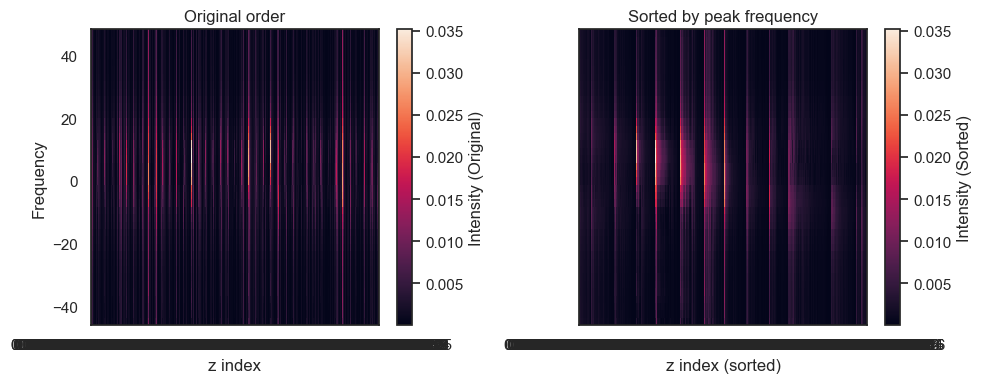

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(z_uniform)
frequencies1 = np.array(frequencies)
S = np.array(true_y_test)

# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [53]:
Sk = np.array(pred_y_test)
Sk_new = Sk[order, :]

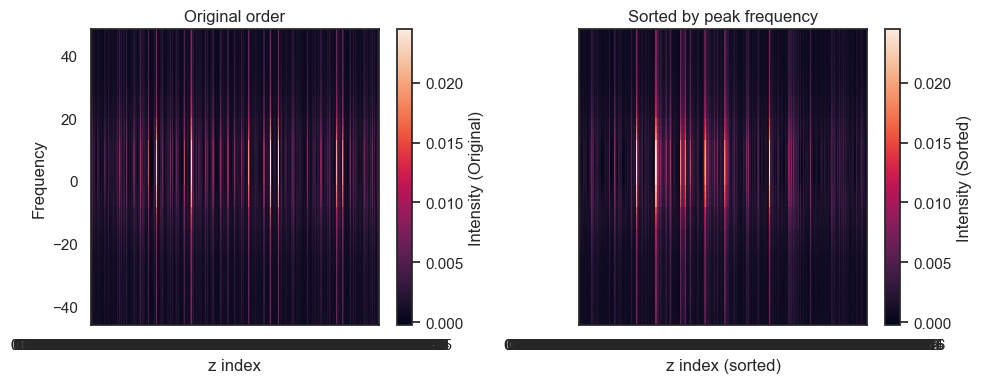

In [54]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [57]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)


✅ Saved spectra_sorted.dat with shape (12800, 4)
